# Program - 

**Purpose**


**Content**
- read data
- plot XY profiles

**Author:** Yi-Hsuan Chen (yihsuan@umich.edu)

**Date:** 

**Reference program:**



In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Read data

### TaiESM1 data

In [2]:
#--- datapath
datapath_TaiESM1 = "/Users/yi-hsuanchen/Downloads/yihsuan/research/data/TaiESM1/data/CMIP6/TaiESM1/amip-hist/atmos/mon/r1i1p1f1/"
fnames_rsut = [
    "rsut_Amon_TaiESM1_amip-hist_r1i1p1f1_gn_197901-201012.nc",
    "rsut_Amon_TaiESM1_amip-hist_r1i1p1f1_gn_201101-201412.nc",
]
fnames_rsut = [datapath_TaiESM1+"/"+file1 for file1 in fnames_rsut]

da_rsut = xr.open_mfdataset(fnames_rsut)


### CERES data

In [3]:
datapath_ceres = "/Users/yi-hsuanchen/Downloads/yihsuan/research/data/CERES/"
fname_ceres = datapath_ceres + "/" + "CERES_EBAF-TOA_Ed4.2_Subset_200101-201412.nc"

da_ceres = xr.open_dataset(fname_ceres)

## Plot - TaiESM1 data

In [4]:
#yhc.lib('pltcn_2d')

Text(0, 0, 'text')

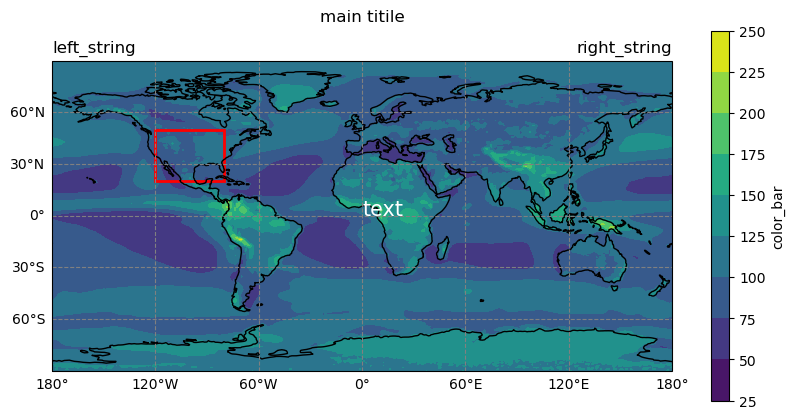

In [5]:
#--- determine map projection
#.     list of map projections: https://scitools.org.uk/cartopy/docs/latest/reference/projections.html
map_projection = ccrs.PlateCarree(central_longitude=0)
#map_projection = ccrs.PlateCarree()

#--- add a cyclic point in lon, otherwise, there will be a white line at the edge
data, lon_cyclic = cutil.add_cyclic_point(da_rsut.rsut.mean("time"), coord=da_rsut.lon)  

#--- plot
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=map_projection)

cn_map_rsut = ax.contourf(lon_cyclic, da_rsut.lat, data, transform=map_projection)

#--- add coast lines
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_global()

#--- add grid lines
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha = 1)  # add lat/lon grid lines
#gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 30))
#gl.ylocator = plt.FixedLocator(np.arange(-90, 90, 15))
gl.top_labels = False
gl.right_labels = False

#--- set tickmarks
#ax.set_xticks(np.arange(-180, 181, 30))
#ax.set_yticks(np.arange(-90, 91, 30))
lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

#--- add texts
ax.set_title("main titile", y=1.1)
ax.set_title("left_string", loc='left')
ax.set_title("right_string", loc='right')

#--- plot a colorbar
cbar = plt.colorbar(cn_map_rsut, ax=ax, orientation='vertical', shrink=0.8, label = "color_bar")
#cbar = plt.colorbar(cn_map_rsut, ax=ax, orientation='horizontal', shrink=0.8, label = "color_bar")

#--- plot a box
lon1, lon2 = -120, -80
lat1, lat2 = 20, 50
rect = mpatches.Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, facecolor='none', edgecolor='red', linewidth=2, transform=map_projection)
ax.add_patch(rect)

#--- add a text
ax.text(0, 0, 'text', fontsize = 15, color = "white")

# Set the extent of the map

#rect = mpatches.Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, facecolor='none', edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())
#ax.plot([30,30],[0,60])


## Plot - CERES data

In [6]:
#da_ceres

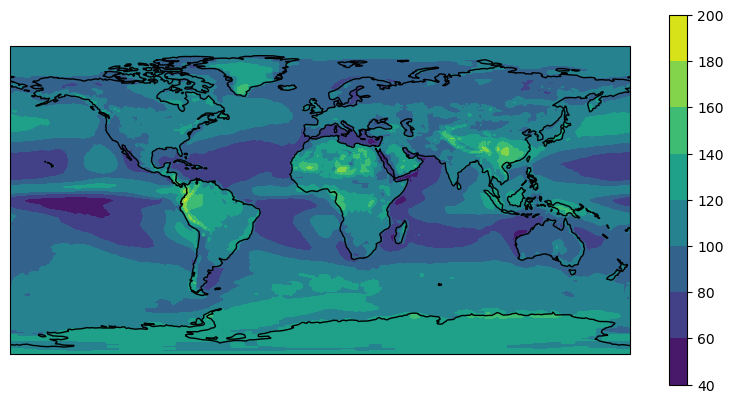

In [7]:
#--- add a cyclic point in lon, otherwise, there will be a white line at the edge
data, lon_cyclic = cutil.add_cyclic_point(da_ceres.toa_sw_all_mon.mean("time"), coord=da_ceres.lon)  

#--- plot
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=map_projection)

cn_map_rsut = ax.contourf(lon_cyclic, da_ceres.lat, data, transform=map_projection)

#--- add coast lines
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
#ax.set_global()

#--- plot a colorbar
cbar = plt.colorbar(cn_map_rsut, ax=ax, orientation='vertical', shrink=0.8)

In [ ]:
#interpolator = RegularGridInterpolator((da_ceres.lat,da_ceres.lon), da_ceres.toa_sw_all_mon.mean("time"), method='linear')

#interp = RegularGridInterpolator((da_ceres.lat,da_ceres.lon), da_ceres.toa_sw_all_mon.mean("time"), method='linear')
#interp

#gg = interp( (da_rsut.lat,da_rsut.lon), )

In [ ]:
source_points = np.vstack((source_lon.ravel(), source_lat.ravel())).T

da_rsut.lat

In [ ]:
#yhc.lib("fdef")   # check out yhc library